# Next step

1. Use volume data to predict volume in the following two hour. Use linear regression model. Fit a model based on the average vlume data for that two hour. 
2. See if volume change vapidly within the two hour time window. 

In [206]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
%matplotlib inline
pd.set_option('display.max_columns', 500)

from __future__ import division

import seaborn as sns

In [207]:
links = pd.read_csv('training/links (table 3).csv')
routes = pd.read_csv('training/routes (table 4).csv')
trajectories = pd.read_csv('training/trajectories(table 5)_training.csv')
volume = pd.read_csv('training/volume(table 6)_training.csv')
weather = pd.read_csv('training/weather (table 7)_training.csv')

submission = pd.read_csv('submission_sample_volume.csv')
test_volume = pd.read_csv('testing_phase1/volume(table 6)_test1.csv')
test_weather = pd.read_csv('testing_phase1/weather (table 7)_test1.csv')
test_trajectories = pd.read_csv('testing_phase1/trajectories(table 5)_test1.csv')

In [208]:
from operator import add

def date_converter(volume, time_label='starting_time'):
    # Initialize lists to store splitted information
    date_list = []
    month_list = []
    day_list = []
    hour_list = []
    minute_list = []
    rounded_min_list = []
    rounded_hour_list = []

    # Splits the 'time' information into month, day, hour and minute
    def date_spliter(date):
        counter = 0
        parts = date.split(" ")
        day_part = parts[0]
        clock_part = parts[1]

        day_parts = day_part.split("-")
        month = int(day_parts[1]) # Extract month from time
        day = int(day_parts[2]) # Extract day from time

        clock_parts = clock_part.split(":")
        hour = int(clock_parts[0]) # Extract hour from time
        minute = int(clock_parts[1]) # Extract minute from time

        rounded_hour = str(hour // 3 * 3)
        rounded_min = str(minute // 20 * 20)

        date_list.append(day_part)
        month_list.append(month)
        day_list.append(day)
        hour_list.append(hour)
        minute_list.append(minute)
        rounded_hour_list.append(rounded_hour)
        rounded_min_list.append(rounded_min)

    # Store info into lists
    for date in volume[time_label]:
        date_spliter(date)

    # Add arrays into the 'volume' SFrame
    volume['month'] = np.array(month_list)
    volume['day'] = np.array(day_list)
    volume['hour'] = np.array(hour_list)
    volume['minute'] = np.array(minute_list)
    volume['date'] = np.array(date_list)
    volume['rounded_hour'] = np.array(rounded_hour_list)
    volume['rounded_min'] = np.array(rounded_min_list)
    
    # Add an colume which combine 'date' and 'rounded_hour'
    slash_list = np.array(['-'] * len(volume['date']))
    volume['date_and_rounded_hour'] = volume['date'] + slash_list + volume['rounded_hour']
    
    slash_list = np.array(['-'] * len(weather['date']))
    
    return (volume)

In [209]:
def create_window_time(df):
    # Construct 'window_time' list which uses date, hour, and rounded minute
    date_list = df['date'] + np.array(['-'] * len(df))
    hour_list = df['hour'].astype(str) + np.array(['-'] * len(df))
    window_time_list = date_list + hour_list + df['rounded_min']
    df['window_time'] = window_time_list
    return df

In [210]:
trajectories = date_converter(trajectories)
test_trajectories = date_converter(test_trajectories)
trajectories = create_window_time(trajectories)
test_trajectories = create_window_time(test_trajectories)

# Filter trajectories by month 9 and 10
trajectories = trajectories[(((trajectories['month'] == 9) & (trajectories['day'] >= 19))
                                | ((trajectories['month'] == 10) & (trajectories['day'] <=17)))]

In [211]:
volume = date_converter(volume, time_label='time')
volume = create_window_time(volume)
all_volume = volume.copy()
volume = volume[volume['direction'] == 0]

In [212]:
# Analysis for 'travel_time'

# 6% of travel_time greater than 200

tt = trajectories['travel_time']
tt1 = [t for t in tt if t > 200]
tt2 = [t for t in tt if t <= 200]

# plt.hist(tt2)

In [213]:
# Group dataframe here
def group_df(df, groupby_inter_id=False):
    
    if groupby_inter_id and 'intersection_id' in df.columns:
        df = df.groupby(['window_time', 'tollgate_id', 'intersection_id'])
    else:
        df = df.groupby(['window_time', 'tollgate_id'])
    df_grouped = df.agg('mean').join(pd.DataFrame(df.size(), columns=['count']))

    # Put index as column
    df_grouped['window_time'] = df_grouped.index.get_level_values('window_time')
#     df_grouped['intersection_id'] = df_grouped.index.get_level_values('intersection_id')
    df_grouped['tollgate_id'] = df_grouped.index.get_level_values('tollgate_id')
    
    return df_grouped


In [214]:
gp_trajectories = group_df(trajectories, True)
gp_trajectories['intersection_id'] = gp_trajectories.index.get_level_values('intersection_id')


In [215]:
pre_gp_trajectories = group_df(trajectories)


In [216]:
gp_volume = group_df(volume)

## Merge data

In [217]:
merged = pd.merge(pre_gp_trajectories[['window_time', 'tollgate_id', 'count']], gp_volume[['window_time', 'tollgate_id', 'count']],
                  how='inner', on=['window_time', 'tollgate_id'], suffixes=('', '_y'))

# Part 1: 'volume' table and 'trajectories' table tendency(festival data included)

1. The first subplot indicates the tendency of 'trajectories' table, the second indicates the tendency of 'volume' table
2. x label: time
    Each number indicates a 20-minute window_time, 
        eg: 0 indicates 2016-9-19 00:00:00 ~  2016-9-19 00:20:00, 
            1 indicates 2016-9-19 00:20:00 ~  2016-9-19 00:40:00,
            .
            .
            .
            1600(not exact number)
3. y label: count(volume), number of vehicles passing the tollgate(or intersection) within the 20-minute window time

### volume and trajectories tendency for tollgate 1, entry

array([[ 1.        ,  0.68060652],
       [ 0.68060652,  1.        ]])

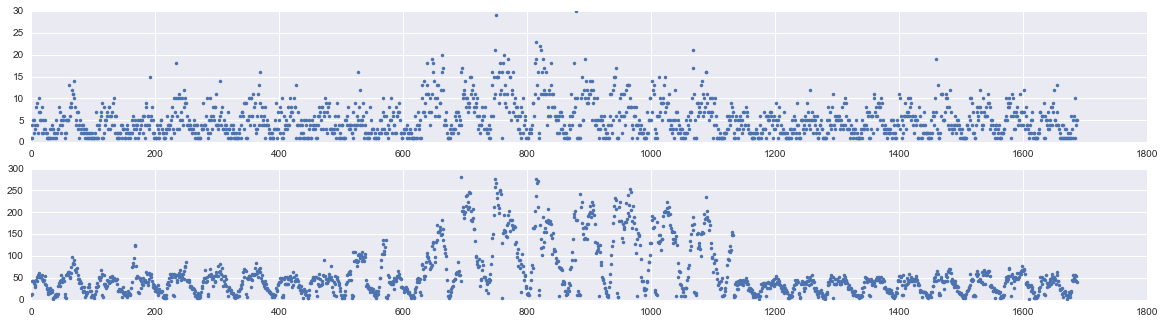

In [218]:
t1 = merged[merged['tollgate_id'] == 1]

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)

ax1.plot(range(len(t1)), t1['count'], '.')
ax2.plot(range(len(t1)), t1['count_y'], '.')
# ax3.plot(range(len(t1)), t1['count'], '.', range(len(t1)), t1['count_y'] / 12, '*')

np.corrcoef(t1['count'], t1['count_y'])

### volume and trajectories tendency for tollgate 2, entry


array([[ 1.        ,  0.26945328],
       [ 0.26945328,  1.        ]])

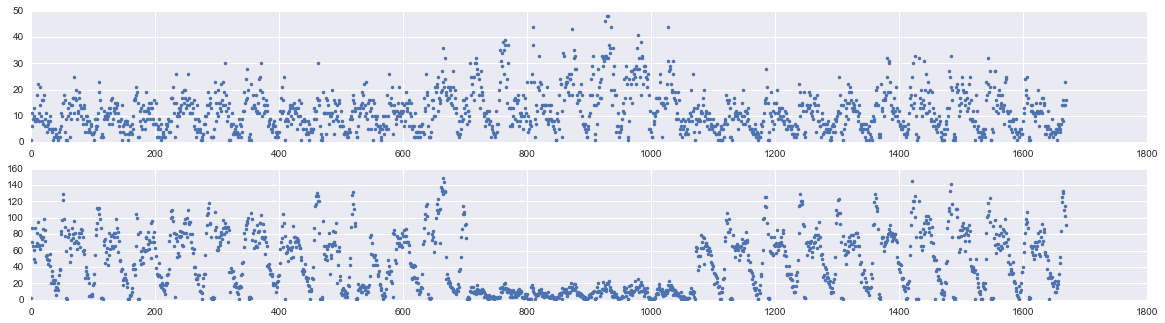

In [219]:
t2 = merged[merged['tollgate_id'] == 2]

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)


ax1.plot(range(len(t2)), t2['count'], '.')
ax2.plot(range(len(t2)), t2['count_y'], '.')
# ax3.plot(range(len(t2)), t2['count'], '.', range(len(t2)), t2['count_y'] / 12, '*')

np.corrcoef(t2['count'], t2['count_y'])

### volume and trajectories tendency for tollgate 3, entry


array([[ 1.       ,  0.8161932],
       [ 0.8161932,  1.       ]])

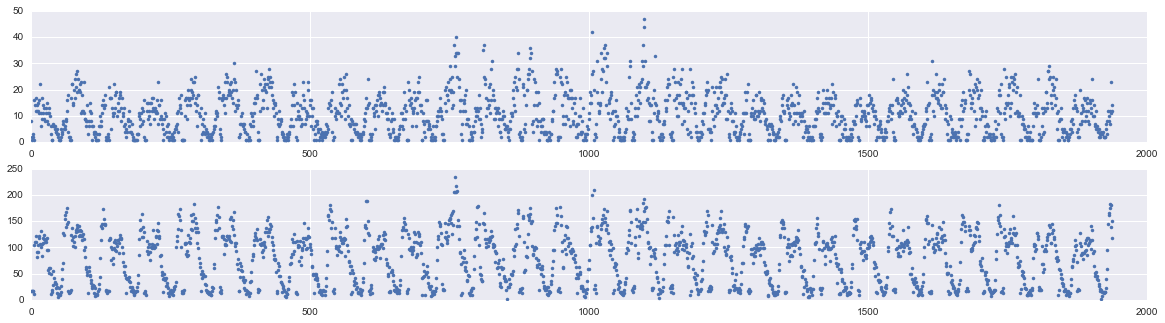

In [220]:
t3 = merged[merged['tollgate_id'] == 3]

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)


ax1.plot(range(len(t3)), t3['count'], '.')
ax2.plot(range(len(t3)), t3['count_y'], '.')
# ax3.plot(range(len(t3)), t3['count'], '.', range(len(t3)), t3['count_y'] / 12, '*')

np.corrcoef(t3['count'], t3['count_y'])

## Create exit data

In [221]:
df = all_volume.groupby(['window_time', 'tollgate_id', 'direction'])
gp_all_volume = df.agg('mean').join(pd.DataFrame(df.size(), columns=['count']))
gp_all_volume['window_time'] = gp_all_volume.index.get_level_values('window_time')
gp_all_volume['tollgate_id'] = gp_all_volume.index.get_level_values('tollgate_id')
gp_all_volume['direction'] = gp_all_volume.index.get_level_values('direction')

In [222]:
gp_all_volume = gp_all_volume[gp_all_volume['hour'].isin([8, 9, 17, 18])]

#### Create 'week_n' feature

In [223]:
gp_all_volume.loc[(gp_all_volume['month'] == 9) 
                      * (gp_all_volume['day'].isin([19, 20, 21, 22, 23, 24, 25])), 'week'] = 1

gp_all_volume.loc[((gp_all_volume['month'] == 9) & (gp_all_volume['day'].isin([26, 27, 28, 29, 30])))
                      | ((gp_all_volume['month'] == 10) & (gp_all_volume['day'].isin([1, 2]))), 'week'] = 2

gp_all_volume.loc[(gp_all_volume['month'] == 10) & (gp_all_volume['day'].isin([3,4,5,6,7,8,9])), 'week'] = 3

gp_all_volume.loc[(gp_all_volume['month'] == 10) & (gp_all_volume['day'].isin([10,11,12,13,14,15,16])), 'week']=4

gp_all_volume.loc[(gp_all_volume['month'] == 10) & (gp_all_volume['day'].isin([17])), 'week'] = 5

#### Create 'weekday' feature

In [224]:
if (9 in list(gp_all_volume['month'].unique())):
    sept = gp_all_volume[gp_all_volume['month'] == 9]
    weekday1 = ((sept['day'] + 3) % 7).values
    octo = gp_all_volume[gp_all_volume['month'] == 10]
    weekday2 = ((octo['day'] + 5) % 7).values
    gp_all_volume['weekday'] = np.append(weekday1, weekday2)
else:
    weekday2 = ((gp_all_volume['day'] + 5) % 7).values
    gp_all_volume['weekday'] = np.array(weekday2)

#### Create 'is_festival' feature

In [225]:
# Construct 'is_festival' column
gp_all_volume['is_festival'] = np.array([0] * len(gp_all_volume))
# sep_days = [15, 16, 17]
oct_days = [1, 2, 3, 4, 5, 6, 7]
# if (9 in list(gp_all_volume['month'].unique())):
#     for day in sep_days:
#         gp_all_volume.loc[((gp_all_volume['month'] == 9) & (gp_all_volume['day'] == day)), 'is_festival'] = 1
for day in oct_days:
    gp_all_volume.loc[((gp_all_volume['month'] == 10) & (gp_all_volume['day'] == day)), 'is_festival'] = 1

In [226]:
nfes_all = gp_all_volume[gp_all_volume['is_festival'] == 0]

In [227]:
nfes_vol_in_1 = nfes_all[(nfes_all['tollgate_id'] == 1) & (nfes_all['direction'] == 0)]
nfes_vol_in_2 = nfes_all[(nfes_all['tollgate_id'] == 2) & (nfes_all['direction'] == 0)]
nfes_vol_in_3 = nfes_all[(nfes_all['tollgate_id'] == 3) & (nfes_all['direction'] == 0)]

nfes_vol_out_1 =  nfes_all[(nfes_all['tollgate_id'] == 1) & (nfes_all['direction'] == 1)]
nfes_vol_out_3 =  nfes_all[(nfes_all['tollgate_id'] == 3) & (nfes_all['direction'] == 1)]

In [228]:
nfes_data = [nfes_vol_in_1, nfes_vol_in_2, nfes_vol_in_3, nfes_vol_out_1, nfes_vol_out_3]

In [229]:
fig = plt.figure()

# Part 2: 'Volume' table distribution(festival data excluded)

1. x label: weekday(0.0 stands for Sunday, 1.0 stands for Monday, 2.0 stands for Tuesday ...)
2. y label: count(volume), number of vehicles passing the tollgate
3. hue: week(eg: The blue bar indicates the data in the first week, 2016-9-19 ~ 2016-9-25)

#### Volume distribution plot for tollgate 1, entry 

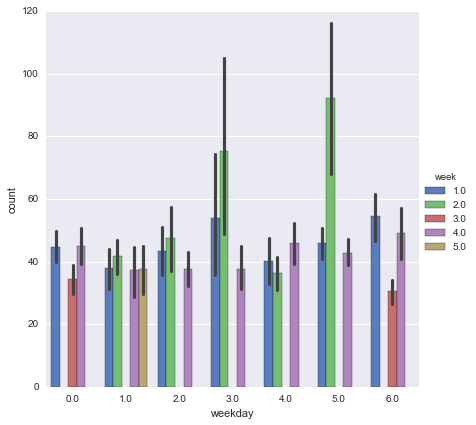

In [260]:
sns.factorplot(x='weekday', y='count', hue='week', data=nfes_vol_in_1, kind='bar', size=6, palette="muted")

#### Volume distribution plot for tollgate 2, entry

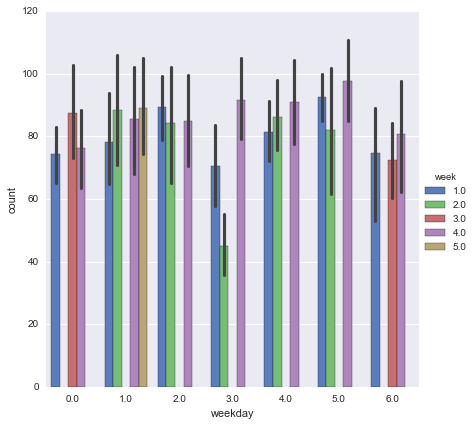

In [231]:
sns.factorplot(x='weekday', y='count', hue='week', data=nfes_vol_in_2, kind='bar', size=6, palette="muted")

#### Volume distribution plot for tollgate 3, entry

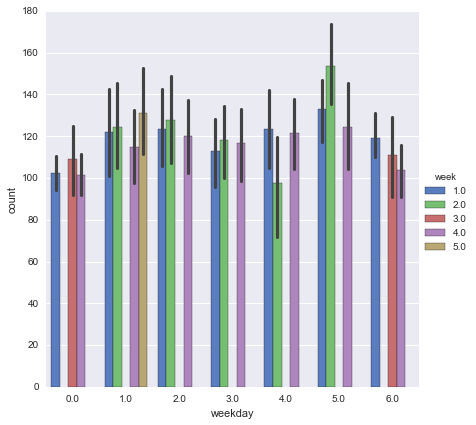

In [232]:
sns.factorplot(x='weekday', y='count', hue='week', data=nfes_vol_in_3, kind='bar', size=6, palette="muted")

#### Volume distribution plot for tollgate 1, exit

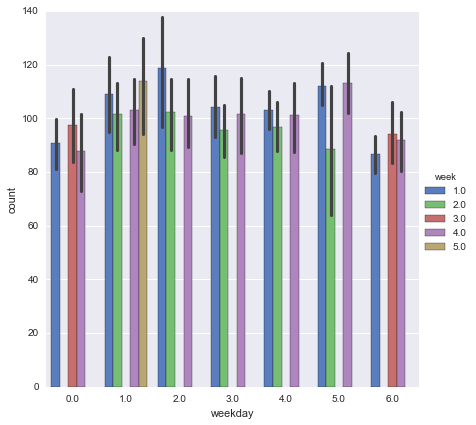

In [233]:
sns.factorplot(x='weekday', y='count', hue='week', data=nfes_vol_out_1, kind='bar', size=6, palette="muted")

#### Volume distribution plot for tollgate 3, exit

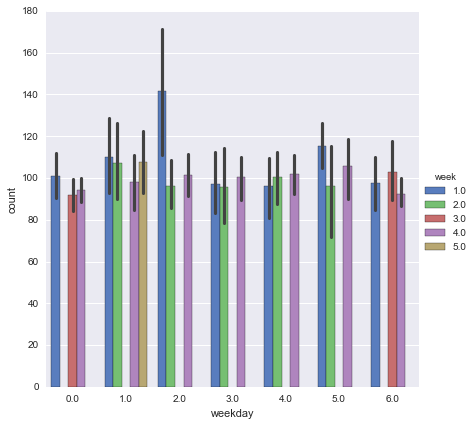

In [234]:
sns.factorplot(x='weekday', y='count', hue='week', data=nfes_vol_out_3, kind='bar', size=6, palette="muted")

In [235]:
# fig = plt.figure(figsize=(20, 24))
# ax1 = fig.add_subplot(511)
# ax2 = fig.add_subplot(512)
# ax3 = fig.add_subplot(513)
# ax4 = fig.add_subplot(514)
# ax5 = fig.add_subplot(515)

# ax1.bar(nfes_vol_in_1['weekday'], nfes_vol_in_1['count'])
# ax2.bar(nfes_vol_in_2['weekday'], nfes_vol_in_2['count'])
# ax3.bar(nfes_vol_in_3['weekday'], nfes_vol_in_3['count'])
# ax4.bar(nfes_vol_out_1['weekday'], nfes_vol_out_1['count'])
# ax5.bar(nfes_vol_out_3['weekday'], nfes_vol_out_3['count'])


### Remove the first day, so number of days in each weekday is consistent

In [236]:
gp_trajectories = gp_trajectories[((gp_trajectories['month'] == 9) & (gp_trajectories['day'] != 19)) |
                                  (gp_trajectories['month'] == 10)] 

In [237]:
if (9 in list(gp_trajectories['month'].unique())):
    sept = gp_trajectories[gp_trajectories['month'] == 9]
    weekday1 = ((sept['day'] + 3) % 7).values
    octo = gp_trajectories[gp_trajectories['month'] == 10]
    weekday2 = ((octo['day'] + 5) % 7).values
    gp_trajectories['weekday'] = np.append(weekday1, weekday2)
else:
    weekday2 = ((gp_all_volume['day'] + 5) % 7).values
    gp_trajectories['weekday'] = np.array(weekday2)

In [238]:
traj_1 = gp_trajectories[gp_trajectories['tollgate_id'] == 1]
traj_2 = gp_trajectories[gp_trajectories['tollgate_id'] == 2]
traj_3 = gp_trajectories[gp_trajectories['tollgate_id'] == 3]

# Part 3: 'trajectories' data distribution

1. x label: weekday
2. y label: count(volume), number of vehicles passing the intersection
3. hue: intersection_id(eg: In the first plot, the blue bar indicates the number of vehicles passing intersection B within 20-min window-time)

#### Tollgate_id 1, entry

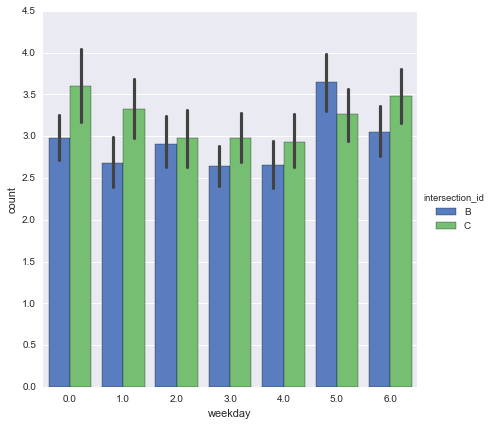

In [239]:
sns.factorplot(x='weekday', y='count', hue='intersection_id', data=traj_1, kind='bar', size=6, palette="muted")

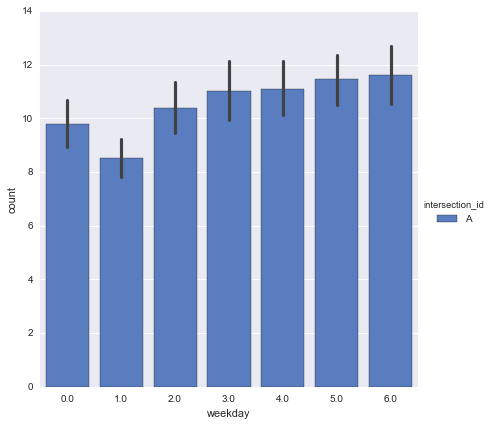

In [240]:
sns.factorplot(x='weekday', y='count', hue='intersection_id', data=traj_2, kind='bar', size=6, palette="muted")

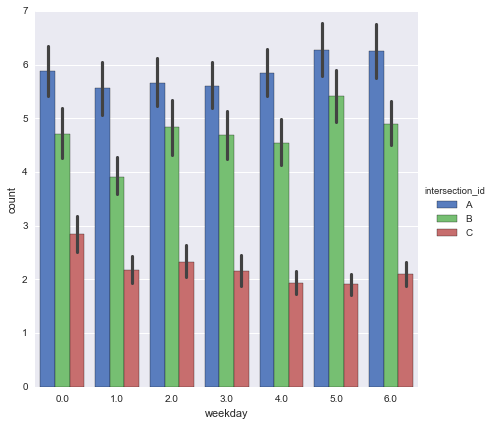

In [241]:
sns.factorplot(x='weekday', y='count', hue='intersection_id', data=traj_3, kind='bar', size=6, palette="muted")

In [242]:
vwgrouped = pd.read_csv('vwgrouped_row.csv')

In [243]:
vwgrouped['is_festival'].unique()

array([0, 1], dtype=int64)

In [244]:
# Construct 'is_festival' column
vwgrouped['is_festival'] = np.array([0] * len(vwgrouped))
oct_days = [1, 2, 3, 4, 5, 6, 7]
for day in oct_days:
    vwgrouped.loc[((vwgrouped['month'] == 10) & (vwgrouped['day'] == day)), 'is_festival'] = 1

In [245]:
vwgrouped = vwgrouped[vwgrouped['is_festival'] == 0]

In [246]:
vw1_in = vwgrouped[(vwgrouped['tollgate_id'] == 1) & (vwgrouped['direction'] == 0)]
vw2_in = vwgrouped[(vwgrouped['tollgate_id'] == 2) & (vwgrouped['direction'] == 0)]
vw3_in = vwgrouped[(vwgrouped['tollgate_id'] == 3) & (vwgrouped['direction'] == 0)]
vw1_out = vwgrouped[(vwgrouped['tollgate_id'] == 1) & (vwgrouped['direction'] == 1)]
vw3_out = vwgrouped[(vwgrouped['tollgate_id'] == 3) & (vwgrouped['direction'] == 1)]

In [247]:
vws = [vw1_in, vw2_in, vw3_in, vw1_out, vw3_out]

In [248]:
def plot_weather(df):

    fig = plt.figure(figsize=(20,12))
    fig.subplots_adjust(hspace=0.3)

    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    ax1.plot(df['precipitation'], df['count'], '.')
    ax2.plot(df['temperature'], df['count'], '.')
    ax3.plot(df['pressure'], df['count'], '.')
    ax4.plot(df['rel_humidity'], df['count'], '.')


    ax1.set_title("Count and Precipitation")
    ax2.set_title("Count and Temperature")
    ax3.set_title("Count and Pressure")
    ax4.set_title("Count and Rel_humidity")
    
    ax1.set_ylabel("count")
    ax2.set_ylabel("count")
    ax3.set_ylabel("count")
    ax4.set_ylabel("count")


# Part 4: correlation between count and weather features(festival data excluded)

1. x label: weather features, 'precipitation', 'temperature', 'pressure', 'rel_humidity')
        'precipitation': (mm)
        'pressure': (Hundred Pa)
2. y label: count

#### Tollgate_id 1, entry

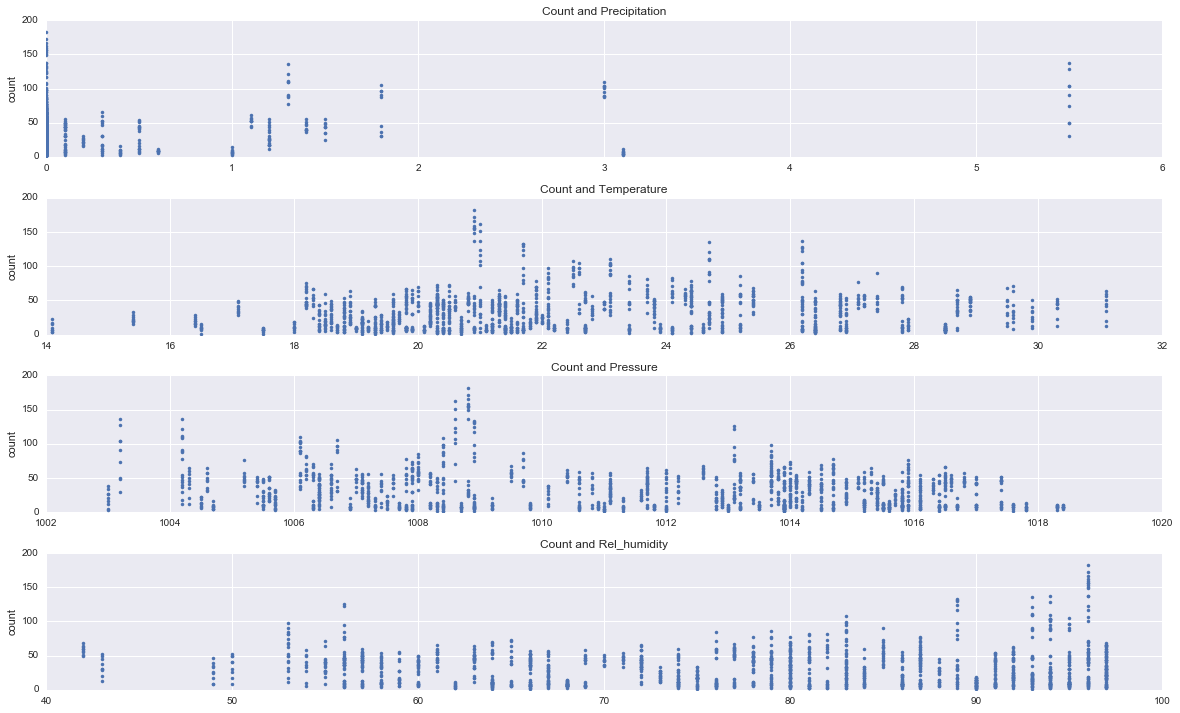

In [249]:
plot_weather(vw1_in)

#### Tollgate_id 2, entry

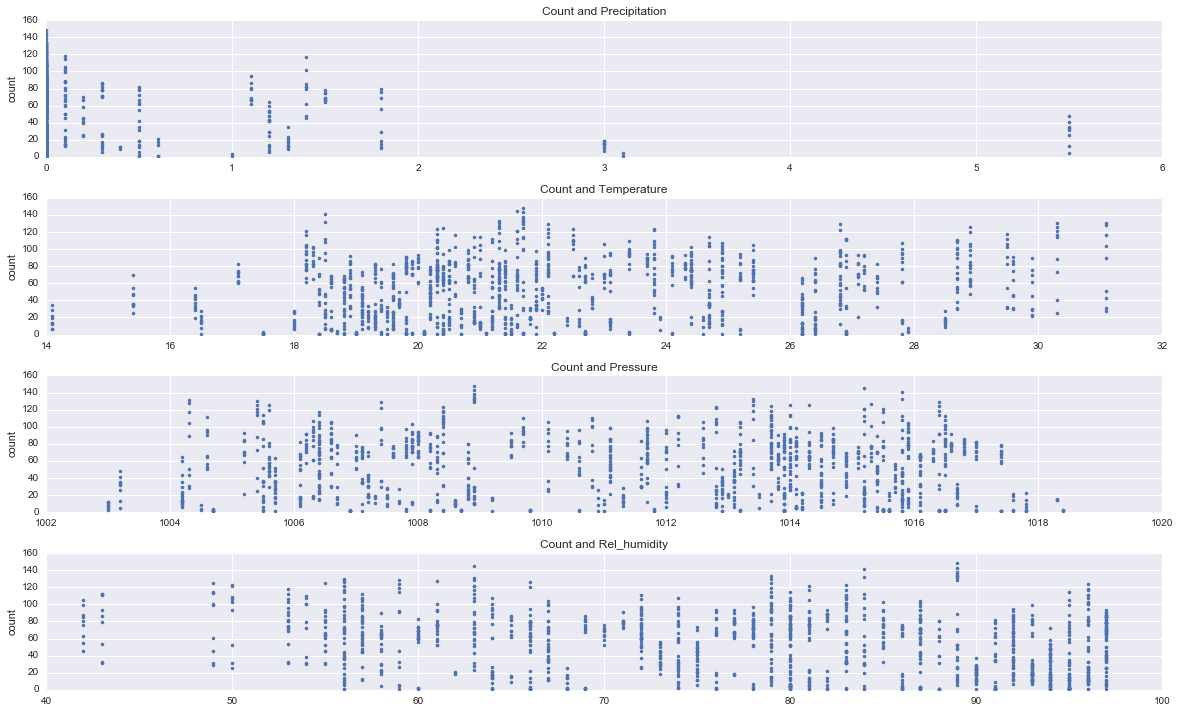

In [250]:
plot_weather(vw2_in)

#### Tollgate_id 3, entry

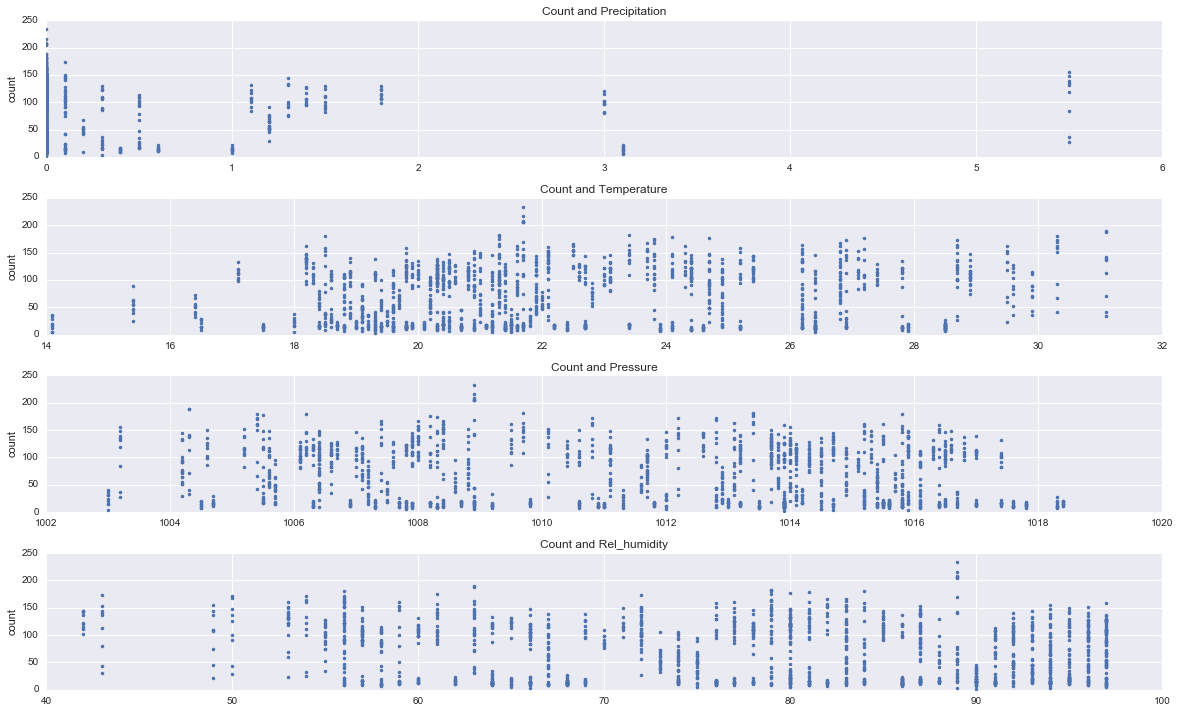

In [251]:
plot_weather(vw3_in)

#### Tollgate_id 1, exit

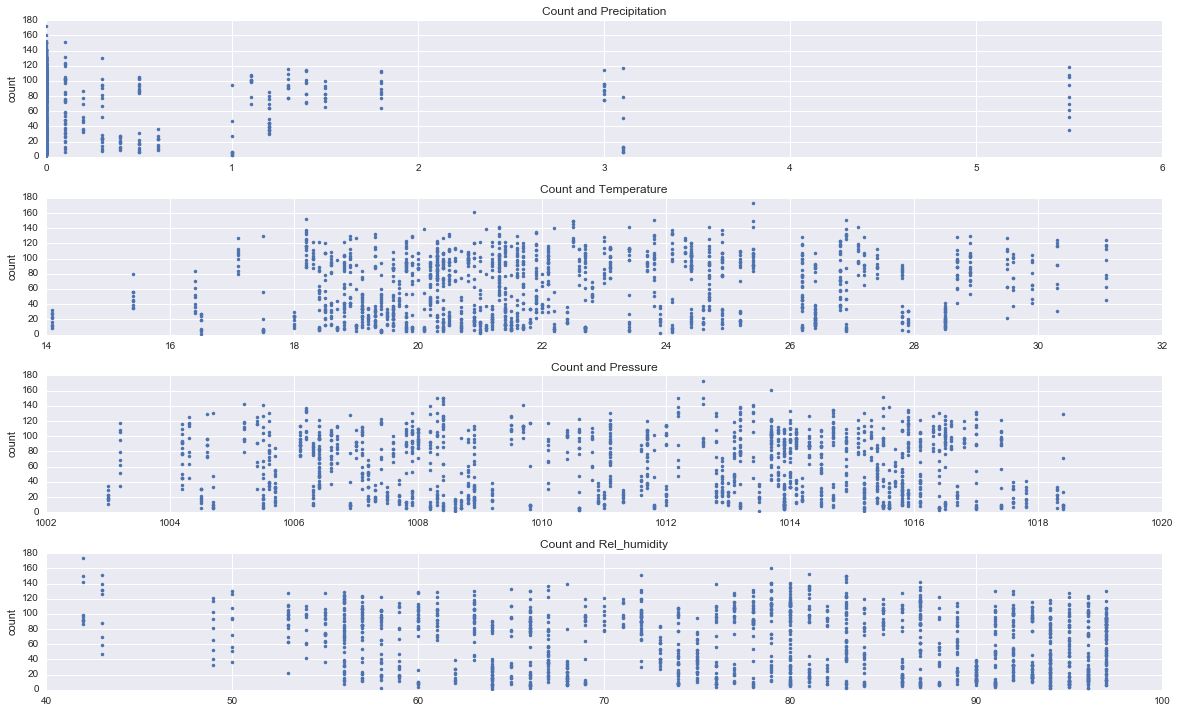

In [252]:
plot_weather(vw1_out)

#### Tollgate_id 3, exit

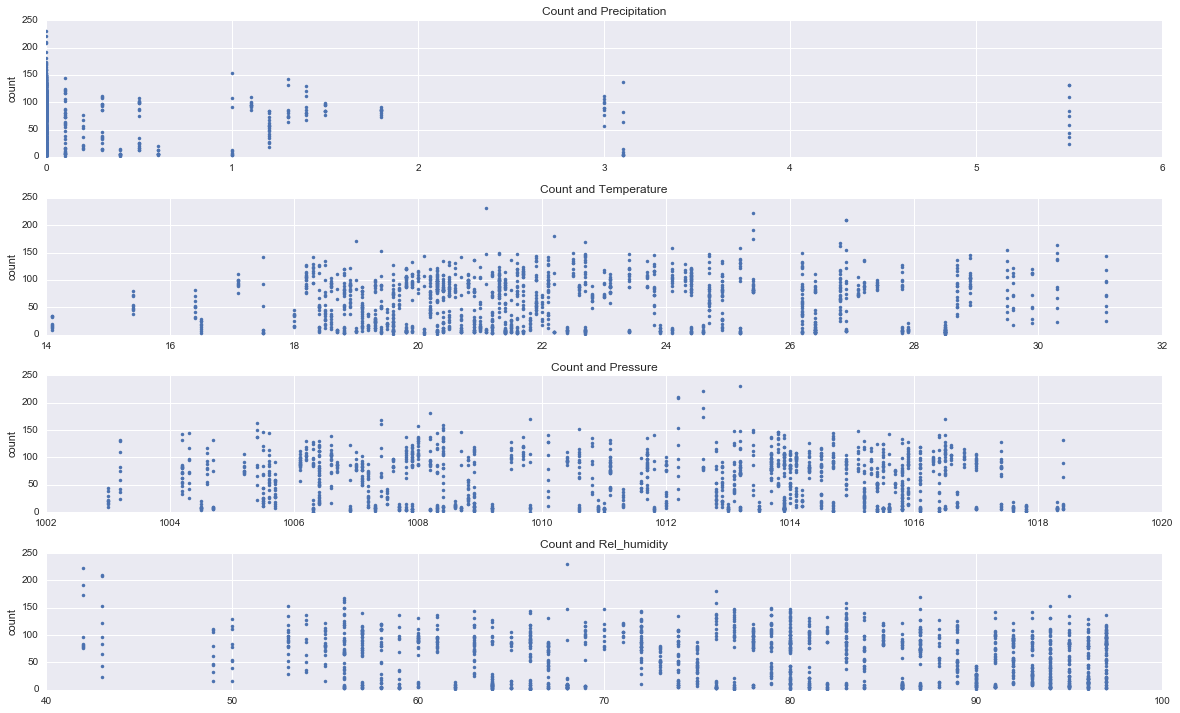

In [253]:
plot_weather(vw3_out)

In [254]:
weathers = ['pressure', 'sea_pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation', 'count']

# Part 5: Correllation Heatmap(festival data excluded)

#### tollgate_id 1, entry

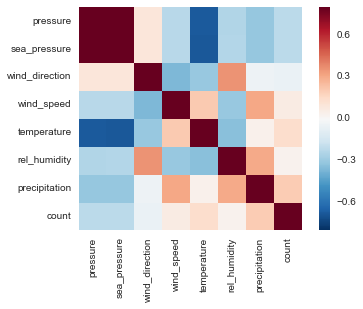

In [255]:
sns.heatmap(vw1_in[weathers].corr(), vmax=0.8, square=True)

#### tollgate_id 2, entry

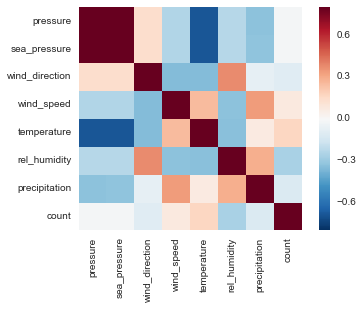

In [256]:
sns.heatmap(vw2_in[weathers].corr(), vmax=0.8, square=True)

#### tollgate_id 3, entry

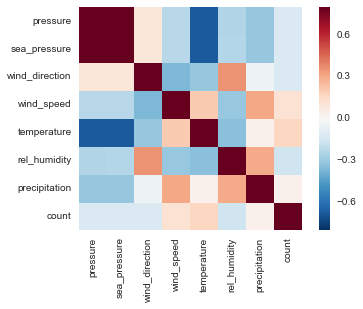

In [257]:
sns.heatmap(vw3_in[weathers].corr(), vmax=0.8, square=True)

#### tollgate_id 1, exit

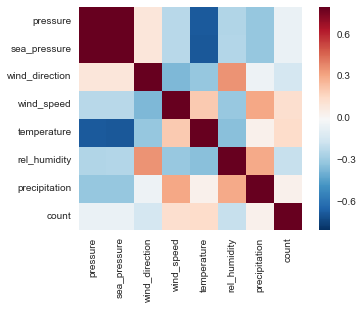

In [258]:
sns.heatmap(vw1_out[weathers].corr(), vmax=0.8, square=True)

#### tollgate_id 3, exit

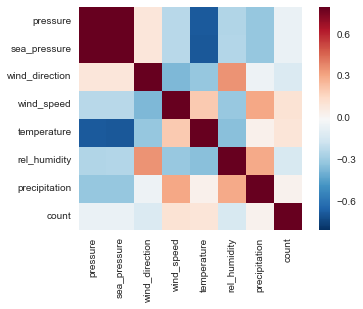

In [259]:
sns.heatmap(vw3_out[weathers].corr(), vmax=0.8, square=True)